<a href="https://colab.research.google.com/github/Akitsuyoshi/recaptch_breaker/blob/main/recaptch_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import necessary libraries

In [11]:
import os
import warnings
import zipfile

import seaborn as sns
import matplotlib.pyplot as plt

In [1]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 14.4 MB/s 
     |████████████████████████████████| 1.3 MB 53.6 MB/s 
     |████████████████████████████████| 441 kB 47.6 MB/s 
     |████████████████████████████████| 5.5 MB 45.2 MB/s 
     |████████████████████████████████| 1.6 MB 50.9 MB/s 
     |████████████████████████████████| 212 kB 15.8 MB/s 
     |████████████████████████████████| 163 kB 62.8 MB/s 
     |████████████████████████████████| 95 kB 2.8 MB/s 
     |████████████████████████████████| 115 kB 8.6 MB/s 
     |████████████████████████████████| 127 kB 29.5 MB/s 
     |████████████████████████████████| 115 kB 50.2 MB/s 
     |████████████████████████████████| 7.6 MB 43.4 MB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *
from fastai.vision.widgets import *

## EDA 

In [ ]:
with zipfile.ZipFile('/content/gdrive/MyDrive/images.zip', 'r') as zip:
  zip.printdir()
  print("extracting all the files now")
  zip.extractall()
  print('Done')

In [4]:
def getting_img_data():
  def sort_dict(unsorted_dict):
    return dict(sorted(unsorted_dict.items(), key=lambda item: item[1], reverse=True))

  images_data = {}
  for i, j, k in os.walk('images'):
    if len(k) > 0:
      images_data[k[0].split(' ')[0]] = len(k)
  
  return sort_dict(images_data)
  
images_data = getting_img_data()

In [5]:
len(images_data.keys()), sum(images_data.values()), images_data

(12,
 11730,
 {'Car': 3558,
  'Other': 1340,
  'Cross': 1240,
  'Bus': 1209,
  'Hydrant': 952,
  'Palm': 911,
  'Tlight': 791,
  'Bicycle': 780,
  'Bridge': 533,
  'Stair': 211,
  'Chimney': 124,
  'Motorcycle': 81})

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


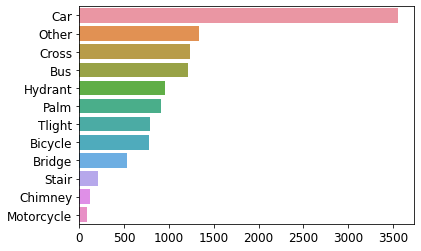

In [12]:
sns.barplot(list(images_data.values()), list(images_data.keys()))

## Create dataset

In [50]:
path = Path('images')

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.8),
    batch_tfms=aug_transforms()
)
dls = dblock.dataloaders(path)
dls.loss_func

FlattenedLoss of CrossEntropyLoss()

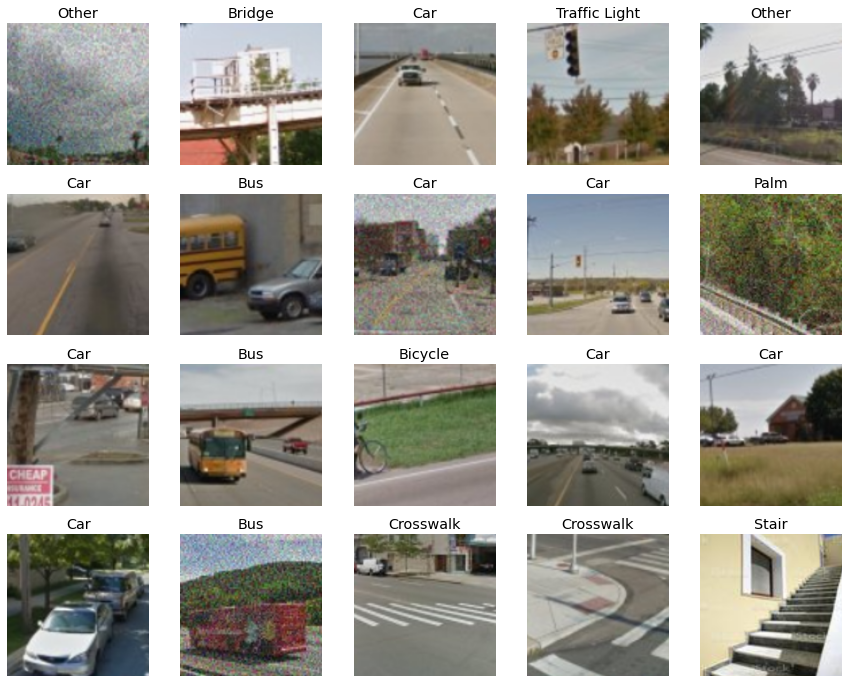

In [8]:
dls.valid.show_batch(max_n=20, nrows=4)

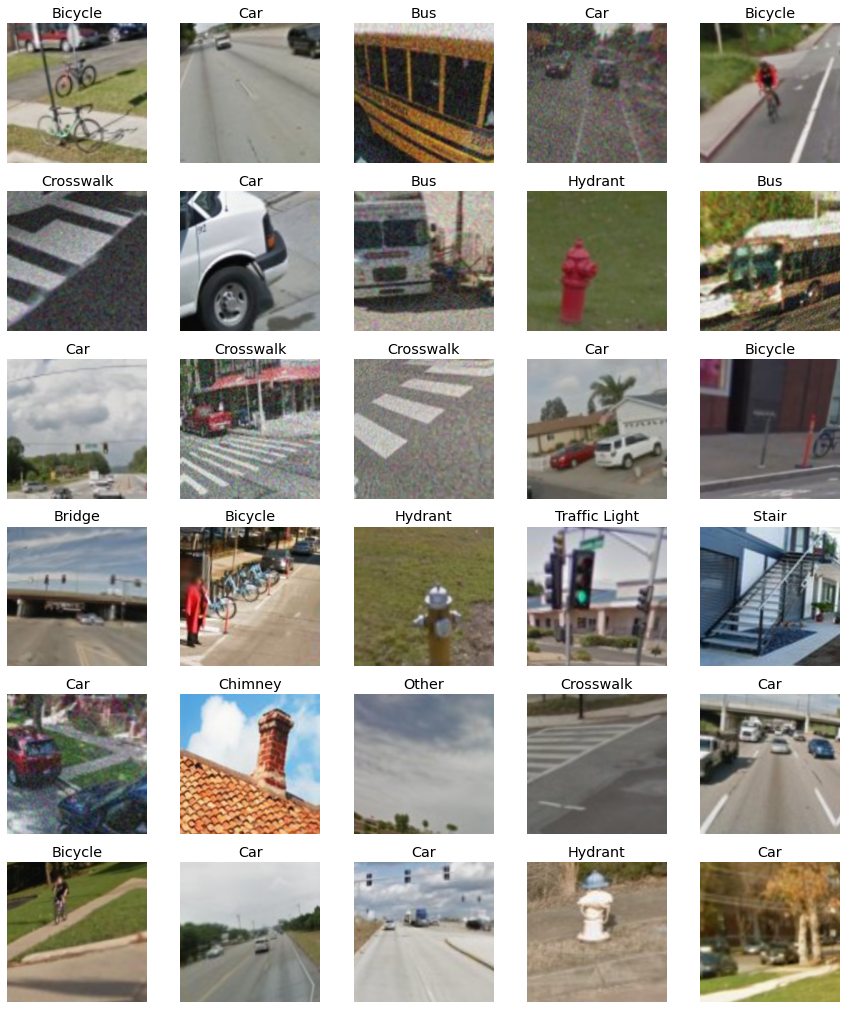

In [9]:
dls.train.show_batch(max_n=30, nrows=6)

## Make baseline model

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0014454397605732083)

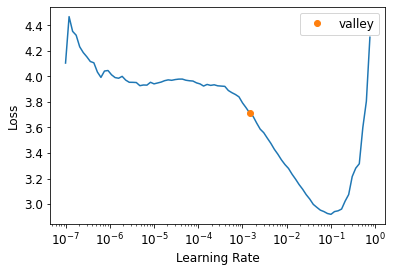

In [10]:
learn = vision_learner(dls, resnet18, metrics=accuracy).to_fp16()
learn.lr_find()

In [13]:
lr = 1.4e-3
learn.fine_tune(6, lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.779093,0.960993,0.710997,00:38


epoch,train_loss,valid_loss,accuracy,time
0,1.044177,0.696547,0.789003,00:38
1,0.765003,0.541180,0.824382,00:35
2,0.581334,0.498159,0.837170,00:35
3,0.487913,0.475835,0.838448,00:35
4,0.427957,0.472397,0.841859,00:36


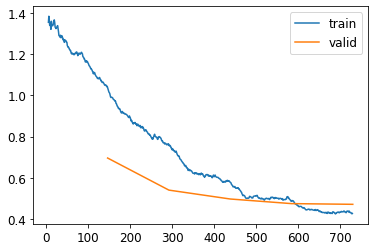

In [14]:
learn.recorder.plot_loss()

(None,
 [('Car', 'Other', 52),
  ('Other', 'Car', 43),
  ('Palm', 'Other', 22),
  ('Other', 'Palm', 19),
  ('Car', 'Bus', 18),
  ('Traffic Light', 'Car', 16),
  ('Crosswalk', 'Car', 15),
  ('Other', 'Traffic Light', 13),
  ('Chimney', 'Other', 11),
  ('Car', 'Crosswalk', 10),
  ('Other', 'Bridge', 10),
  ('Palm', 'Car', 10)])

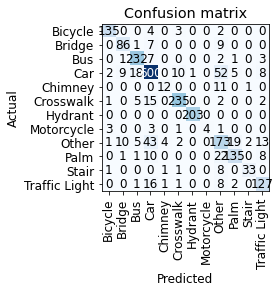

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(), interp.most_confused(min_val=10)

In [16]:
learn.export('baseline_model.pkl')

## Finetune imbalanced weights algorithmically

In [51]:
class_weights = [np.sqrt(sum(images_data.values()) / (2.0 * val)) for key, val in images_data.items()]
class_weights

[1.2838995195852483,
 2.0920959996237722,
 2.1748192360923744,
 2.2025250566815746,
 2.482078621984865,
 2.537317528708787,
 2.7229882447481595,
 2.7421215817740046,
 3.317190429447149,
 5.2722109717656105,
 6.877382285199376,
 8.509254221575908]

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.0020892962347716093)

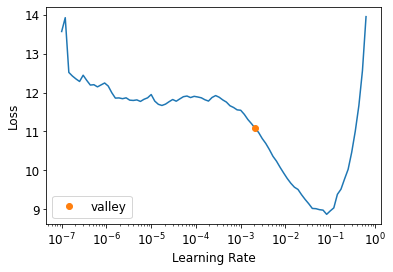

In [52]:
# Add precising
dblock = dblock.new(
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.8)
)
dls = dblock.dataloaders(path)
loss_func = CrossEntropyLossFlat(weight=torch.FloatTensor(class_weights).cuda())
learn = vision_learner(dls, resnet18, loss_func=loss_func, metrics=accuracy).to_fp16()
learn.lr_find()

In [53]:
lr = 2e-3
learn.fine_tune(8, lr)

epoch,train_loss,valid_loss,accuracy,time
0,5.053125,2.956502,0.683717,01:00


epoch,train_loss,valid_loss,accuracy,time
0,2.867874,2.030167,0.782182,01:00
1,2.208539,1.666575,0.811594,01:00
2,1.831970,1.481216,0.823529,01:00
3,1.428731,1.487238,0.822677,01:00
4,1.281328,1.472942,0.823956,01:00
5,1.030708,1.333173,0.835891,01:00
6,0.971574,1.349703,0.851662,01:00
7,0.692185,1.320388,0.849531,01:00
8,0.597952,1.463019,0.841432,01:00
9,0.494921,1.354349,0.855072,01:00


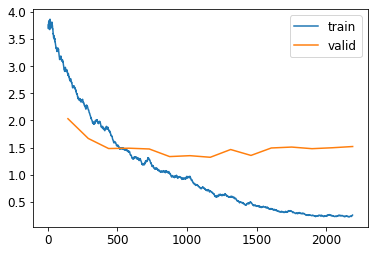

In [54]:
learn.recorder.plot_loss()

In [55]:
learn.export('weighted_loss_model.pkl')

## Oversampling while training

In [56]:
wgts = pd.Series(1 / np.array(list(images_data.values())), index=images_data.keys())
wgts, sum(images_data.values())

(Car           0.000281
 Other         0.000746
 Cross         0.000806
 Bus           0.000827
 Hydrant       0.001050
 Palm          0.001098
 Tlight        0.001264
 Bicycle       0.001282
 Bridge        0.001876
 Stair         0.004739
 Chimney       0.008065
 Motorcycle    0.012346
 dtype: float64, 11730)

In [57]:
df_data = {'image': [], 'label': []}

for p, d, f in os.walk('images'):
  for file in f:
    label = f[0].split(' ')[0]
    df_data['image'].append(p + '/' + file)
    df_data['label'].append(label)
df = pd.DataFrame(df_data)
df = df.merge(wgts.rename('wgts'), left_on='label', right_index=True)
df.tail()

,image,label,wgts
11725,images/Bridge/Bridge (231).png,Bridge,0.001876
11726,images/Bridge/Bridge (468).png,Bridge,0.001876
11727,images/Bridge/Bridge (308).png,Bridge,0.001876
11728,images/Bridge/Bridge (364).png,Bridge,0.001876
11729,images/Bridge/Bridge (403).png,Bridge,0.001876


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.02290867641568184)

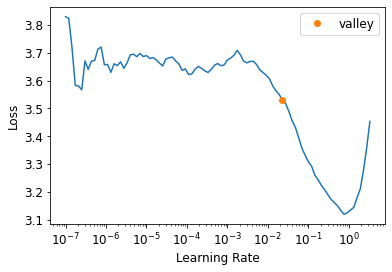

In [67]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader('image'),
    get_y=ColReader('label'),
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.8)
)
dataset = dblock.datasets(df)
dls = dataset.weighted_dataloaders(wgts=dataset.train.items['wgts'],
                                   after_batch=dblock.batch_tfms,
                                   after_item=dblock.item_tfms)
# dls.show_batch()
learn = vision_learner(dls, resnet18, metrics=accuracy).to_fp16()
learn.lr_find()

In [68]:
lr = 2e-2
learn.fine_tune(10, lr)

epoch,train_loss,valid_loss,accuracy,time
0,2.249890,1.026384,0.528133,01:01


epoch,train_loss,valid_loss,accuracy,time
0,1.255299,0.858456,0.602302,01:01
1,1.001068,0.666447,0.663257,01:01
2,0.784136,0.569242,0.702899,01:02
3,0.647386,0.535973,0.716539,01:01
4,0.575471,0.464120,0.740409,01:01
5,0.521006,0.454122,0.751492,01:01
6,0.490292,0.447401,0.747656,01:03
7,0.467588,0.424158,0.758312,01:02
8,0.458947,0.414867,0.765985,01:02
9,0.478794,0.421964,0.764280,01:01


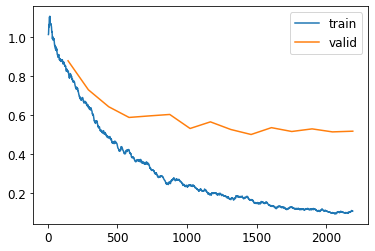

In [60]:
learn.recorder.plot_loss()

(None,
 [('Car', 'Other', 44),
  ('Other', 'Car', 30),
  ('Car', 'Bridge', 17),
  ('Car', 'Cross', 17),
  ('Other', 'Palm', 17),
  ('Car', 'Bus', 16),
  ('Other', 'Tlight', 15),
  ('Palm', 'Other', 15),
  ('Other', 'Bridge', 12),
  ('Chimney', 'Other', 11),
  ('Car', 'Tlight', 10),
  ('Tlight', 'Car', 10)])

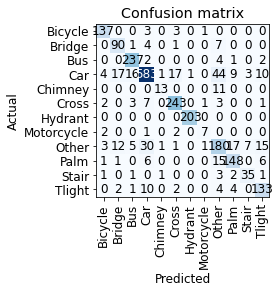

In [61]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(), interp.most_confused(min_val=10)

In [ ]:
learn.export('oversample_model.pkl')